In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
import tensorflow as tf
import os

plt.style.use('ggplot')

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/sample_submission.csv')

In [3]:
train['has_cactus'] = train['has_cactus'].astype('str')
train['has_cactus'].value_counts()

1    13136
0     4364
Name: has_cactus, dtype: int64

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
train_df, valid_df = train_test_split(train, test_size=0.1, stratify=train['has_cactus'], random_state=42)

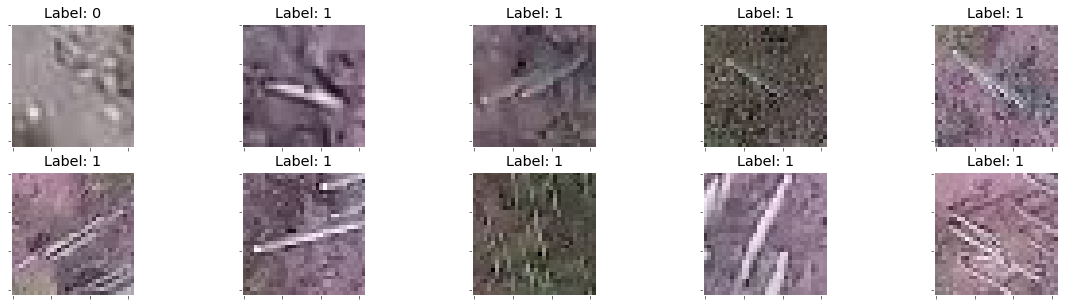

In [6]:
rows, cols = (2, 5)

fig, ax = plt.subplots(rows,cols,figsize=(20,5))

for j in range(rows):
    for i, sample in enumerate(train_df[j * cols:rows * cols - (cols * (rows - (j + 1)))].values):
        path = os.path.join('../input/train/train', sample[0])
        ax[j][i].imshow(img.imread(path))
        ax[j][i].set_title('Label: ' + str(sample[1]))
        ax[j][i].grid(False)
        ax[j][i].set_xticklabels([])
        ax[j][i].set_yticklabels([])

In [7]:
datagen_train = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255., 
                                                                vertical_flip=True, horizontal_flip=True,)
datagen_valid = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [8]:
img_size = 224

In [9]:
train_data = datagen_train.flow_from_dataframe(dataframe=train_df, directory='../input/train/train',
                                               x_col='id', y_col='has_cactus', batch_size=64,
                                               class_mode='binary', target_size=(img_size, img_size))


validation_data = datagen_valid.flow_from_dataframe(dataframe=valid_df,directory='../input/train/train',
                                                    x_col='id', y_col='has_cactus', batch_size=64,
                                                    class_mode='binary', target_size=(img_size, img_size))

Found 15750 images belonging to 2 classes.
Found 1750 images belonging to 2 classes.


In [10]:
model_vgg16 = tf.keras.applications.VGG16(include_top=False, input_shape=(img_size, img_size, 3))

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 3s 0us/step


In [11]:
for layer in model_vgg16.layers:
    layer.trainable = False

In [12]:
flat1 = tf.keras.layers.Flatten()(model_vgg16.layers[-1].output)
class1 = tf.keras.layers.Dense(256, activation='relu')(flat1)
drop1 = tf.keras.layers.Dropout(0.5)(class1)
class2 = tf.keras.layers.Dense(256, activation='relu')(class1)
drop2 = tf.keras.layers.Dropout(0.5)(class2)
output = tf.keras.layers.Dense(1, activation='sigmoid')(class2)

model_vgg16 = tf.keras.models.Model(inputs=model_vgg16.inputs, outputs=output)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [13]:
model_vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [14]:
adadelta = tf.keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
model_vgg16.compile(optimizer=adadelta, loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_best_model.h5",
                                                   save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [16]:
history = model_vgg16.fit(train_data, epochs=100,
                          validation_data=validation_data, 
                          callbacks=[checkpoint_cb, early_stopping_cb])

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
247/247 [==============================] - 85s 342ms/step - loss: 0.2476 - acc: 0.8942 - val_loss: 0.1032 - val_acc: 0.9577
Epoch 2/100
247/247 [==============================] - 54s 218ms/step - loss: 0.1173 - acc: 0.9516 - val_loss: 0.1596 - val_acc: 0.9303
Epoch 3/100
247/247 [==============================] - 54s 218ms/step - loss: 0.0977 - acc: 0.9595 - val_loss: 0.1201 - val_acc: 0.9474
Epoch 4/100
247/247 [==============================] - 54s 220ms/step - loss: 0.0858 - acc: 0.9670 - val_loss: 0.0695 - val_acc: 0.9743
Epoch 5/100
247/247 [==============================] - 54s 217ms/step - loss: 0.0771 - acc: 0.9713 - val_loss: 0.0813 - val_acc: 0.9686
Epoch 6/100
247/247 [==============================] - 54s 218ms/step - loss: 0.0702 - acc: 0.9731 - val_loss: 0.0776 - val_acc: 0.9703
Epoch 7/100
247/247 [==============================] - 54s 219ms/step - loss: 0.0623 - acc: 0.9768 - val_loss: 0.0527 - val_acc: 0.9811


Epoch 37/100
247/247 [==============================] - 53s 213ms/step - loss: 0.0300 - acc: 0.9890 - val_loss: 0.0347 - val_acc: 0.9869
Epoch 38/100
247/247 [==============================] - 53s 213ms/step - loss: 0.0281 - acc: 0.9905 - val_loss: 0.0300 - val_acc: 0.9914
Epoch 39/100
247/247 [==============================] - 53s 213ms/step - loss: 0.0277 - acc: 0.9902 - val_loss: 0.0357 - val_acc: 0.9897
Epoch 40/100
247/247 [==============================] - 52s 212ms/step - loss: 0.0278 - acc: 0.9897 - val_loss: 0.0420 - val_acc: 0.9863
Epoch 41/100
247/247 [==============================] - 53s 213ms/step - loss: 0.0295 - acc: 0.9891 - val_loss: 0.0338 - val_acc: 0.9874
Epoch 42/100
247/247 [==============================] - 53s 213ms/step - loss: 0.0264 - acc: 0.9903 - val_loss: 0.0322 - val_acc: 0.9909
Epoch 43/100
247/247 [==============================] - 52s 211ms/step - loss: 0.0251 - acc: 0.9909 - val_loss: 0.0323 - val_acc: 0.9914
Epoch 44/100
247/247 [===================

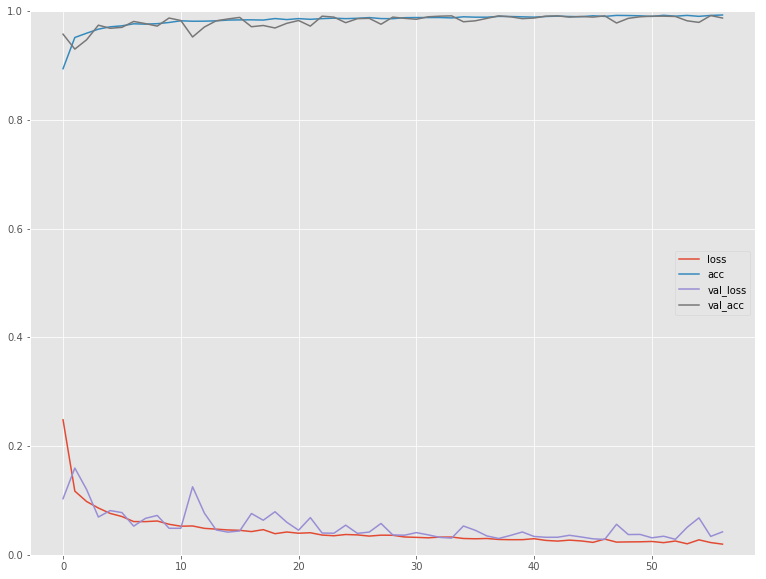

In [17]:
history_df = pd.DataFrame(history.history)
history_df.plot(figsize=(13, 10))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [18]:
test_data = datagen_valid.flow_from_dataframe(dataframe=test, directory="../input/test/test",
                                              x_col="id", y_col=None, shuffle=False, 
                                              class_mode=None, target_size=(img_size, img_size))

Found 4000 images.


In [19]:
answer = pd.DataFrame({'id': test['id']})

In [20]:
answer['has_cactus'] = model_vgg16.predict(test_data, verbose=True)

125/125 [==============================] - 14s 114ms/step


In [21]:
answer.head()

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.996163
1,0017242f54ececa4512b4d7937d1e21e.jpg,1.000000
2,001ee6d8564003107853118ab87df407.jpg,0.013956
3,002e175c3c1e060769475f52182583d0.jpg,0.005772
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.896094


In [22]:
answer.to_csv('submission.csv',  sep=',' , line_terminator='\n', index=False)